In [9]:
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import pmdarima as pm
from pmdarima import auto_arima
from math import sqrt

import os
import warnings
from dataclasses import dataclass
from typing import List, Dict, Tuple


from IPython.display import Image

In [2]:
df_merged = pd.read_csv('merged_hydro_climate.csv')

In [3]:
df_merged.head(5)

,date_time,Source,current_mean,current_max,current_std,power_factor_mean,kwh_sum,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),...,Snowfall (mm),Snow Cover (%),date,time,consumer_device,data_user,voltage_value,is_red,is_blue,is_yellow
0,2023-06-03 13:00:00,consumer_device_3_data_user_11,0.0,0.0,0.0,0.0,0.0,7.199731,-2.448126,-0.034195,...,0.0,99.972656,2023-06-03,13:00:00,consumer_device_3,11,0.0,0,0,1
1,2023-06-03 13:00:00,consumer_device_3_data_user_3,0.0,0.0,0.0,0.0,0.0,7.199731,-2.448126,-0.034195,...,0.0,99.972656,2023-06-03,13:00:00,consumer_device_3,3,0.0,1,0,0
2,2023-06-03 13:00:00,consumer_device_3_data_user_6,0.0,0.0,0.0,0.0,0.0,7.199731,-2.448126,-0.034195,...,0.0,99.972656,2023-06-03,13:00:00,consumer_device_3,6,0.0,0,1,0
3,2023-06-03 13:00:00,consumer_device_3_data_user_10,0.0,0.0,0.0,0.0,0.0,7.199731,-2.448126,-0.034195,...,0.0,99.972656,2023-06-03,13:00:00,consumer_device_3,10,0.0,1,0,0
4,2023-06-03 13:00:00,consumer_device_3_data_user_5,0.0,0.0,0.0,0.0,0.0,7.199731,-2.448126,-0.034195,...,0.0,99.972656,2023-06-03,13:00:00,consumer_device_3,5,0.0,0,0,1


In [3]:
df_merged['date_time'] = pd.to_datetime(df_merged['date_time'])

In [5]:
df_merged.tail(5)

,date_time,Source,current_mean,current_max,current_std,power_factor_mean,kwh_sum,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),...,Snowfall (mm),Snow Cover (%),date,time,consumer_device,data_user,voltage_value,is_red,is_blue,is_yellow
3262636,2024-09-23 23:00:00,consumer_device_6_data_user_7,0.000000,0.00,0.000000,0.000000,0.000000,4.977533,0.843713,0.055191,...,0.0,0.0,2024-09-23,23:00:00,consumer_device_6,7,0.0000,0,1,0
3262637,2024-09-23 23:00:00,consumer_device_10_data_user_3,0.107500,0.11,0.004523,0.385000,0.008021,4.977533,0.843713,0.055191,...,0.0,0.0,2024-09-23,23:00:00,consumer_device_10,3,197.6050,0,0,1
3262638,2024-09-23 23:00:00,consumer_device_35_data_user_6,1.715000,1.94,0.169196,0.833333,0.286159,4.977533,0.843713,0.055191,...,0.0,0.0,2024-09-23,23:00:00,consumer_device_35,6,199.5425,1,0,0
3262639,2024-09-23 23:00:00,consumer_device_31_data_user_6,0.000000,0.00,0.000000,0.000000,0.000000,4.977533,0.843713,0.055191,...,0.0,0.0,2024-09-23,23:00:00,consumer_device_31,6,0.0000,0,1,0
3262640,2024-09-23 23:00:00,consumer_device_12_data_user_3,0.943333,1.01,0.055814,0.367500,0.065902,4.977533,0.843713,0.055191,...,0.0,0.0,2024-09-23,23:00:00,consumer_device_12,3,185.9750,0,0,1


In [6]:
df_merged.columns

Index(['date_time', 'Source', 'current_mean', 'current_max', 'current_std',
       'power_factor_mean', 'kwh_sum', 'Temperature (°C)',
       'Dewpoint Temperature (°C)', 'U Wind Component (m/s)',
       'V Wind Component (m/s)', 'Total Precipitation (mm)', 'Snowfall (mm)',
       'Snow Cover (%)', 'date', 'time', 'consumer_device', 'data_user',
       'voltage_value', 'is_red', 'is_blue', 'is_yellow'],
      dtype='object')

Moved from hourly to Daily forecasting

In [10]:
df_daily_merged = pd.read_csv('daily_merged_hydro_climate.csv')

In [16]:
df_daily_merged.tail(5)

,date,Source,current_mean,current_max,current_std,power_factor_mean,kwh_sum,Temperature (°C)_mean,Temperature (°C)_min,Temperature (°C)_max,...,V Wind Component (m/s)_mean,Total Precipitation (mm)_sum,Snowfall (mm)_sum,Snow Cover (%)_mean,consumer_device,data_user,voltage_value,is_red,is_blue,is_yellow
136404,2024-09-23,consumer_device_8_data_user_10,0.086007,0.10,0.010036,0.744965,0.316940,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_8,10,203.113368,1,0,0
136405,2024-09-23,consumer_device_28_data_user_10,8.006736,23.97,4.669972,0.728542,26.101382,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_28,10,181.688160,1,0,0
136406,2024-09-23,consumer_device_10_data_user_13,0.015000,0.07,0.022770,0.220486,0.048129,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_10,13,190.297118,1,0,0
136407,2024-09-23,consumer_device_36_data_user_16,0.070069,0.08,0.004495,0.747569,0.261421,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_36,16,206.630625,0,0,1
136408,2024-09-23,consumer_device_22_data_user_12,0.023611,0.05,0.024526,0.354340,0.062540,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_22,12,104.095278,1,0,0


In [17]:
df_daily_merged.columns

Index(['date', 'Source', 'current_mean', 'current_max', 'current_std',
       'power_factor_mean', 'kwh_sum', 'Temperature (°C)_mean',
       'Temperature (°C)_min', 'Temperature (°C)_max',
       'Dewpoint Temperature (°C)_mean', 'Dewpoint Temperature (°C)_min',
       'Dewpoint Temperature (°C)_max', 'U Wind Component (m/s)_mean',
       'V Wind Component (m/s)_mean', 'Total Precipitation (mm)_sum',
       'Snowfall (mm)_sum', 'Snow Cover (%)_mean', 'consumer_device',
       'data_user', 'voltage_value', 'is_red', 'is_blue', 'is_yellow'],
      dtype='object')

Devices data range: 2023-06-03 12:25:00 to 2024-09-23 23:55:00. 
Climate data range: 2023-06-03 13:00:00 to 2024-10-25 00:00:00. 
Overlap range: 2023-06-03 13:00:00 to 2024-09-23 23:55:00.

In [7]:
df = df_daily_merged.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

Feature Importance / Correlation Check from Dataset

In [65]:
# Aggregate by date (sum kWh, mean climate/device values)
df_agg = df.groupby('date').agg({
    'kwh_sum':'sum',
    'current_mean':'mean',
    'current_max':'max',
    'current_std':'mean',
    'power_factor_mean':'mean',
    'Temperature (°C)_mean':'mean',
    'Temperature (°C)_min':'min',
    'Temperature (°C)_max':'max',
    'Dewpoint Temperature (°C)_mean':'mean',
    'Dewpoint Temperature (°C)_min':'min',
    'Dewpoint Temperature (°C)_max':'max',
    'U Wind Component (m/s)_mean':'mean',
    'V Wind Component (m/s)_mean':'mean',
    'Total Precipitation (mm)_sum':'sum',
    'Snowfall (mm)_sum':'sum',
    'Snow Cover (%)_mean':'mean',
    'voltage_value':'mean',
    'is_red':'sum',
    'is_blue':'sum',
    'is_yellow':'sum',
    'consumer_device':'nunique',
    'data_user':'nunique'
}).rename(columns={'consumer_device':'consumer_count','data_user':'user_count'}).reset_index()

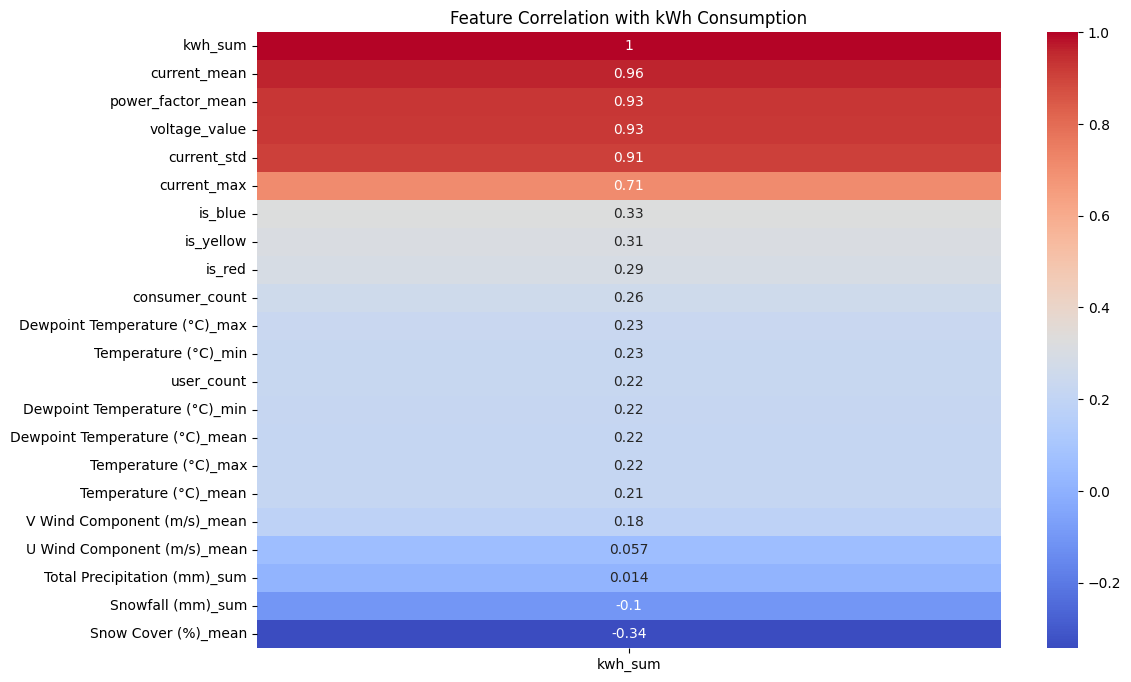

In [68]:
# Correlation heatmap
plt.figure(figsize=(12,8))
corr = df_agg.drop(columns=['date']).corr()
sns.heatmap(corr[['kwh_sum']].sort_values(by='kwh_sum', ascending=False), annot=True, cmap="coolwarm")
plt.title("Feature Correlation with kWh Consumption")
plt.show()


In [66]:
from sklearn.ensemble import RandomForestRegressor

X = df_agg.drop(['date','kwh_sum'], axis=1)  # all numeric
y = df_agg['kwh_sum']

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)


RandomForestRegressor(n_estimators=200, random_state=42)

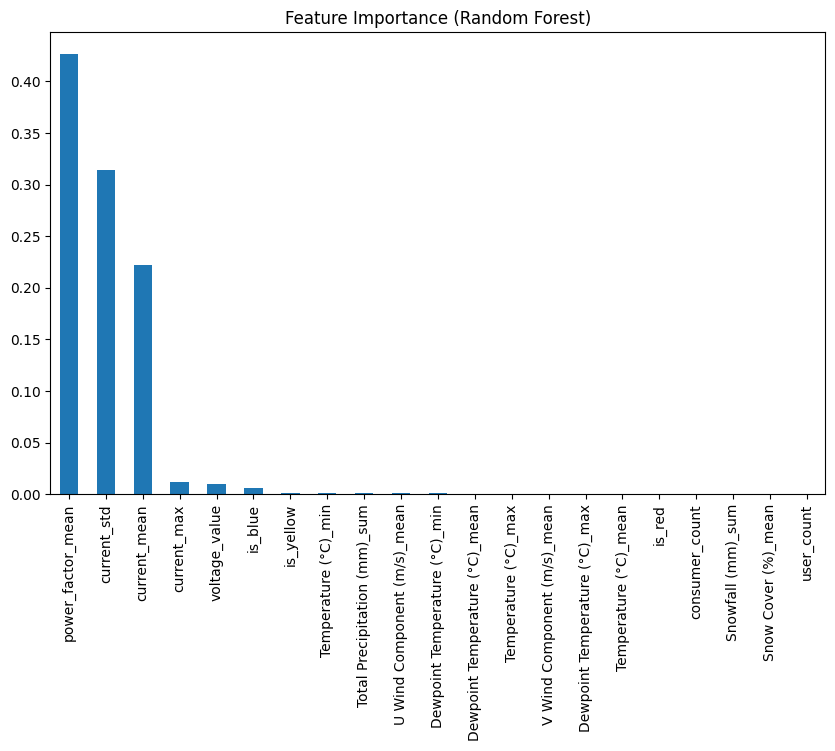

In [67]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances.plot(kind='bar')
plt.title("Feature Importance (Random Forest)")
plt.show()

In [ ]:
# Keep main climate and device columns
features = [
    'kwh_sum',
    'Temperature (°C)_mean',
    'Total Precipitation (mm)_sum',
    'Snowfall (mm)_sum',
    'Snow Cover (%)_mean',
    'Dewpoint Temperature (°C)_mean',
    'current_mean',
    'current_max',
    'power_factor_mean',
    'voltage_value'
]


In [50]:
df = df[features]

# Create simple lag features
df['lag1'] = df['kwh_sum'].shift(1)
df['lag7'] = df['kwh_sum'].shift(7)
df['roll7'] = df['kwh_sum'].rolling(7).mean()
df['roll30'] = df['kwh_sum'].rolling(30).mean()
df['HDD'] = np.maximum(0, 18 - df['Temperature (°C)_mean'])
df['CDD'] = np.maximum(0, df['Temperature (°C)_mean'] - 22)

df = df.dropna()


Feature Importance / Correlation Check including lags and roll.

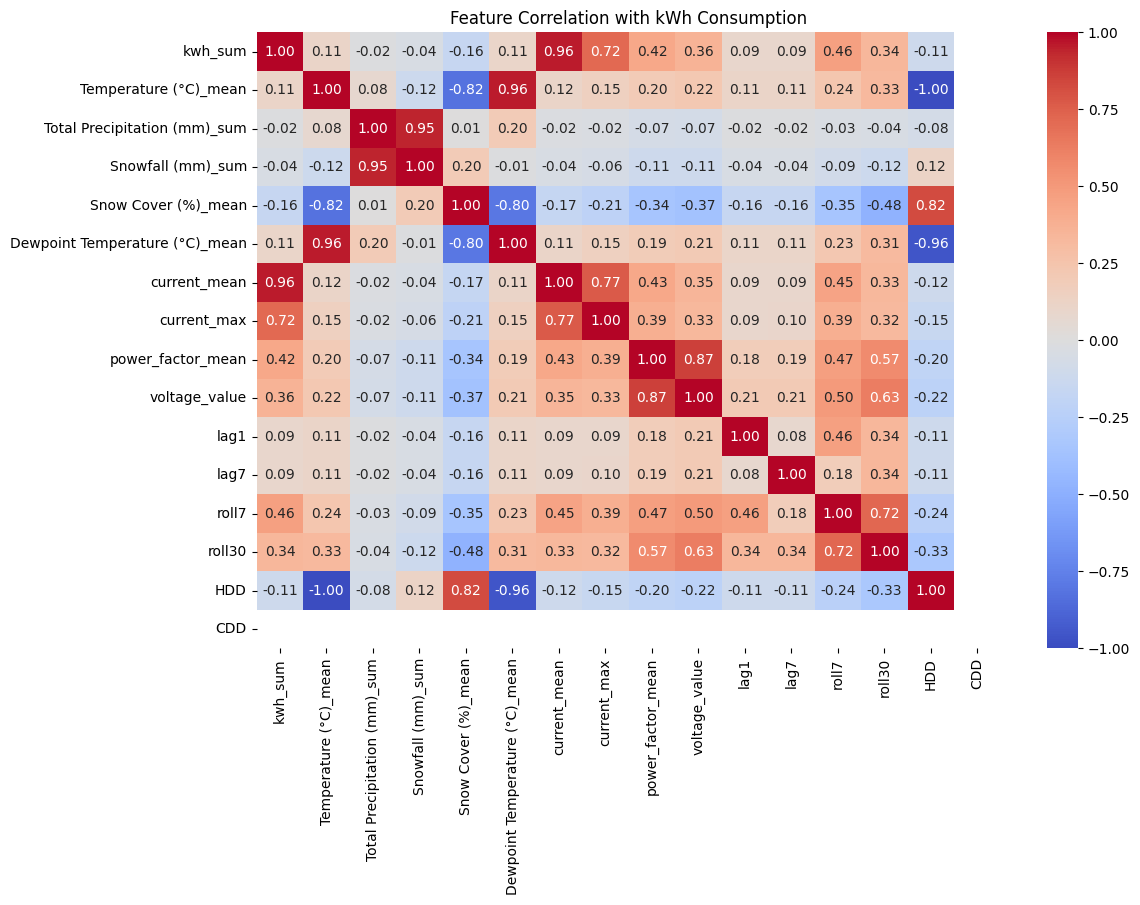

In [20]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation with kWh Consumption")
plt.show()

This heatmap shows visually which features are most correlated with the target (kwh_sum). Assumption:
Strong positive correlation: precipitation, lag1, lag7, roll7, snow cover (inflow drivers)
Moderate correlation: temperature, current_mean, voltage_value
Low correlation: wind components (we may skip them for simplicity)

Feature Importance Using Random Forest

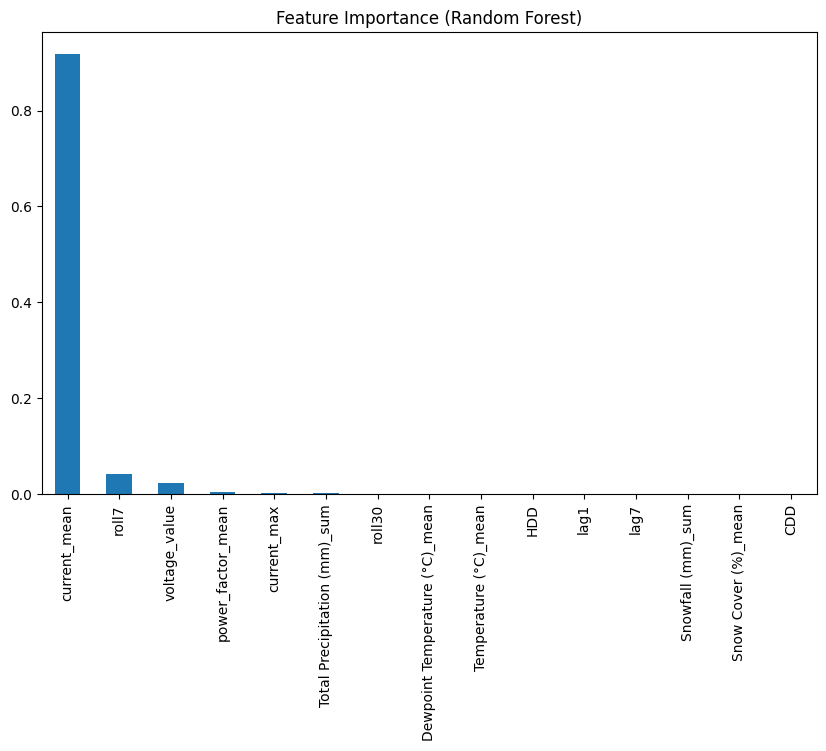

In [10]:
from sklearn.ensemble import RandomForestRegressor

X = df.drop('kwh_sum', axis=1)
y = df['kwh_sum']

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances.plot(kind='bar')
plt.title("Feature Importance (Random Forest)")
plt.show()

Ranking of features in terms of predictive power, which helps decide what to keep in SARIMAX/Prophet.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=847.406, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=856.984, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=860.228, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=859.827, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=855.108, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=847.731, Time=0.18 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=847.755, Time=0.18 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=848.979, Time=0.77 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=848.956, Time=0.84 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=845.895, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=844.089, Time=0.04 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=845.905, Time=0.11 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=845.873, Time=0.12 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=845.526, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=842.5

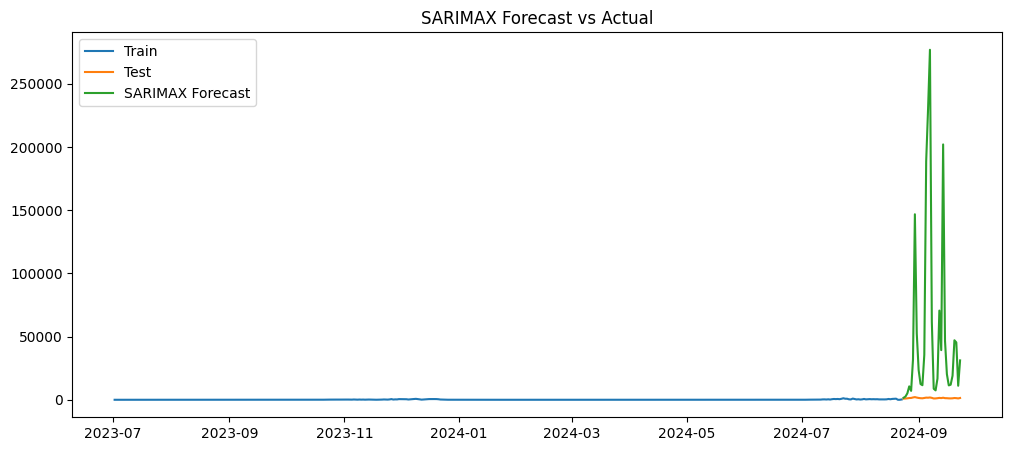

11:25:02 - cmdstanpy - INFO - Chain [1] start processing
11:25:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 190.27976244356952
Prophet MAE: 155.218984837725


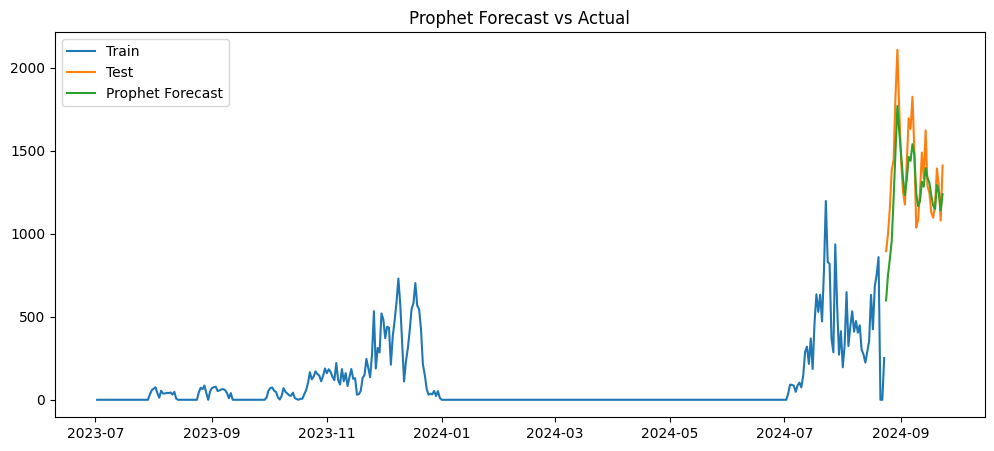

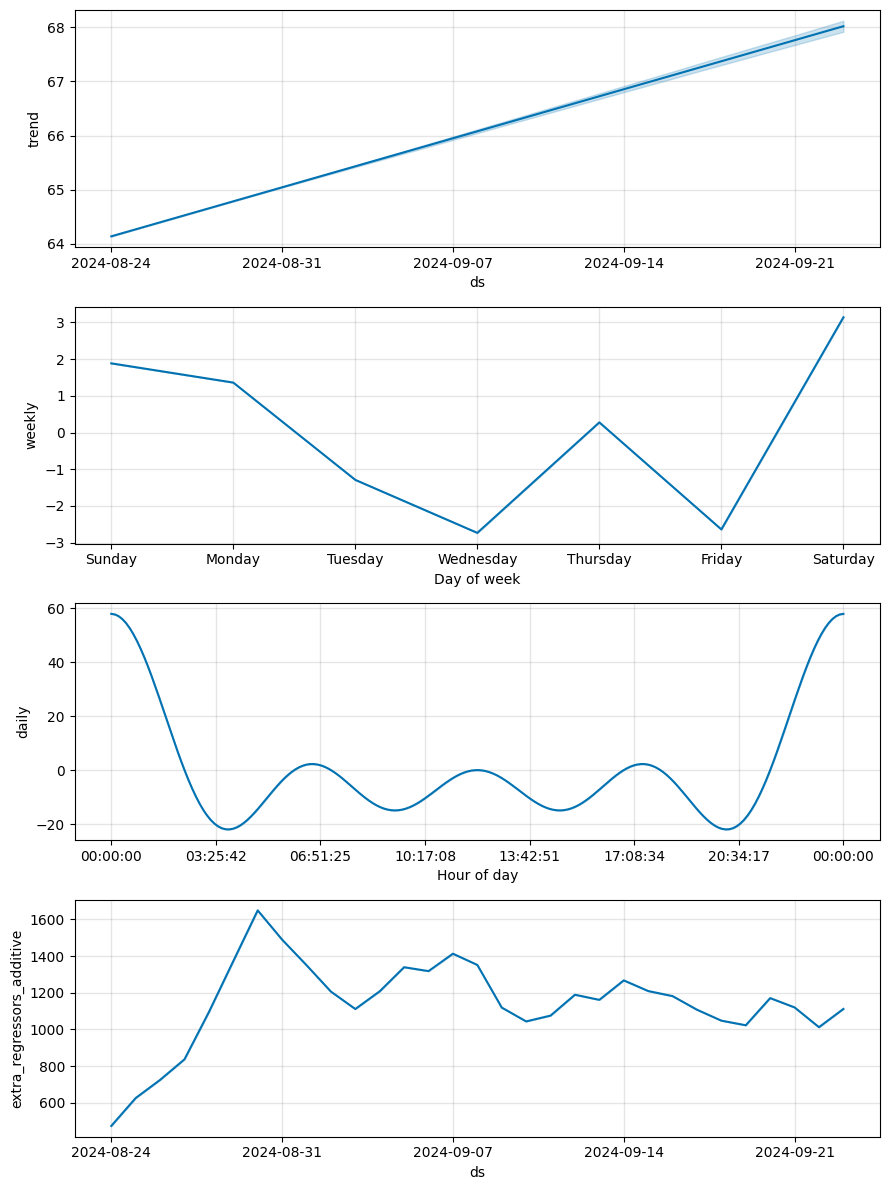

Random Forest RMSE: 516.091989821918
Random Forest MAE: 458.5334844253443


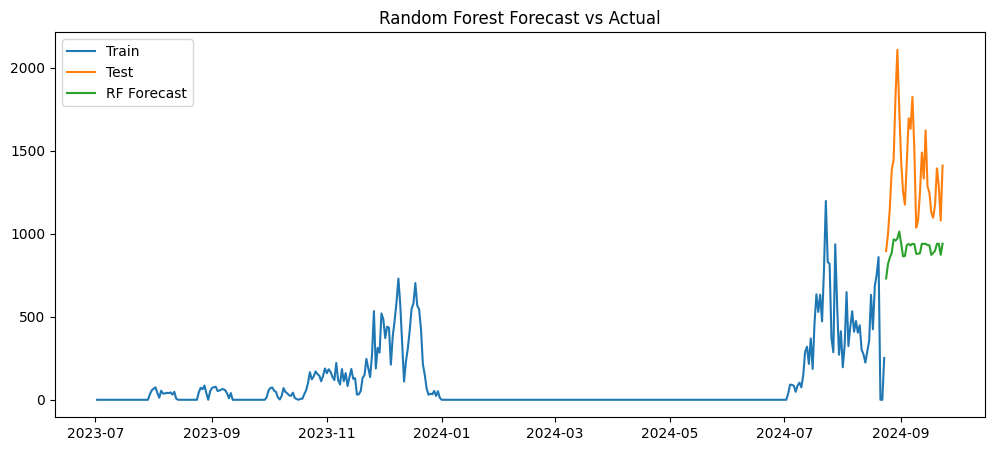

Ensemble RMSE: 331.9294996894962
Ensemble MAE: 282.276451673317


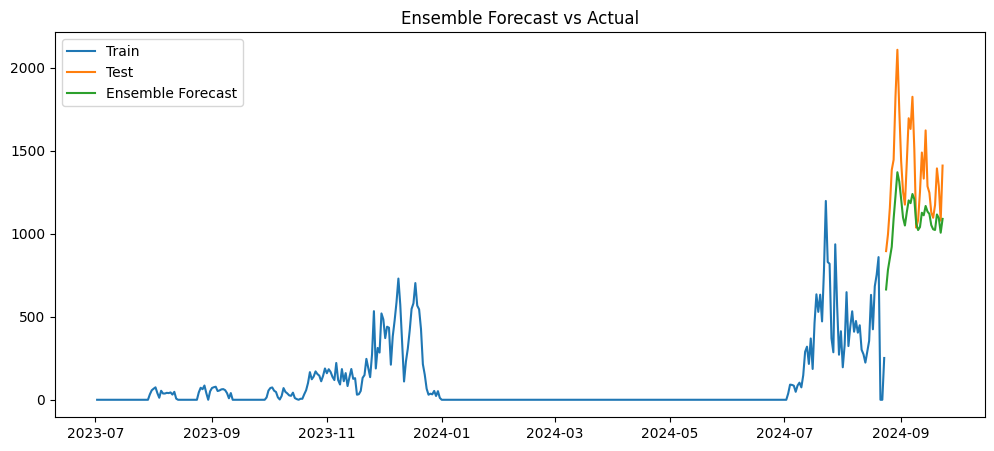

In [ ]:
# Aggregate duplicates
df = df.groupby(df.index).agg({
    'kwh_sum': 'sum',
    'Temperature (°C)_mean': 'mean',
    'Total Precipitation (mm)_sum': 'sum',
    'current_mean': 'mean',
    'current_max': 'max',
    'power_factor_mean': 'mean',
    'voltage_value': 'mean'
})

# Daily frequency + interpolate missing days
df = df.asfreq('D').interpolate()

# Feature Engineering
df['lag1'] = df['kwh_sum'].shift(1)
df['lag7'] = df['kwh_sum'].shift(7)
df['roll7'] = df['kwh_sum'].rolling(7).mean()
df['roll30'] = df['kwh_sum'].rolling(30).mean()
df = df.dropna()

# Train-test split
train = df.loc[:'2024-08-23']
test = df.loc['2024-08-24':'2024-09-23']


# SARIMAX
exog_sarimax = ['lag1','lag7','Temperature (°C)_mean','current_mean']
X_train_sarimax = train[exog_sarimax]
X_test_sarimax  = test[exog_sarimax]
y_train_sarimax = train['kwh_sum']
y_test_sarimax  = test['kwh_sum']

# Log transform
y_train_log = np.log1p(y_train_sarimax.clip(lower=1))

# Auto ARIMA to select best order
smodel = pm.auto_arima(
    y_train_log,
    exogenous=X_train_sarimax,
    seasonal=True,
    m=7,
    stepwise=True,
    trace=True
)

sarimax = SARIMAX(
    y_train_log,
    exog=X_train_sarimax,
    order=smodel.order,
    seasonal_order=smodel.seasonal_order
)

sarimax_fit = sarimax.fit(disp=False)
sarimax_pred_log = sarimax_fit.predict(
    start=y_test_sarimax.index[0], 
    end=y_test_sarimax.index[-1], 
    exog=X_test_sarimax
)
sarimax_pred = np.expm1(sarimax_pred_log)

# Evaluation
print("SARIMAX RMSE:", sqrt(mean_squared_error(y_test_sarimax, sarimax_pred)))
print("SARIMAX MAE:", mean_absolute_error(y_test_sarimax, sarimax_pred))

# Plot SARIMAX
plt.figure(figsize=(12,5))
plt.plot(train.index, y_train_sarimax, label="Train")
plt.plot(test.index, y_test_sarimax, label="Test")
plt.plot(test.index, sarimax_pred, label="SARIMAX Forecast")
plt.legend(); plt.title("SARIMAX Forecast vs Actual"); plt.show()

# Prophet
exog_features = ['lag1','lag7','roll7','roll30','current_mean','Temperature (°C)_mean','Total Precipitation (mm)_sum']
prophet_df = df.reset_index()[['date','kwh_sum'] + exog_features].rename(columns={'date':'ds','kwh_sum':'y'})

prophet_train = prophet_df[prophet_df['ds'] <= '2024-08-23']
prophet_test  = prophet_df[(prophet_df['ds'] >= '2024-08-24') & (prophet_df['ds'] <= '2024-09-23')]

prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)
for col in exog_features:
    prophet.add_regressor(col)

prophet.fit(prophet_train)

future_test = prophet_test[['ds'] + exog_features]
forecast = prophet.predict(future_test)

print("Prophet RMSE:", sqrt(mean_squared_error(prophet_test['y'], forecast['yhat'])))
print("Prophet MAE:", mean_absolute_error(prophet_test['y'], forecast['yhat']))

# Plot Prophet
plt.figure(figsize=(12,5))
plt.plot(prophet_train['ds'], prophet_train['y'], label="Train")
plt.plot(prophet_test['ds'], prophet_test['y'], label="Test")
plt.plot(prophet_test['ds'], forecast['yhat'], label="Prophet Forecast")
plt.legend(); plt.title("Prophet Forecast vs Actual"); plt.show()

prophet.plot_components(forecast)
plt.show()


# Random Forest
X_train_rf = train[exog_features]
X_test_rf  = test[exog_features]
y_train_rf = train['kwh_sum']
y_test_rf  = test['kwh_sum']

rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train_rf, y_train_rf)
rf_pred = rf.predict(X_test_rf)

print("Random Forest RMSE:", sqrt(mean_squared_error(y_test_rf, rf_pred)))
print("Random Forest MAE:", mean_absolute_error(y_test_rf, rf_pred))

# Plot RF
plt.figure(figsize=(12,5))
plt.plot(train.index, y_train_rf, label="Train")
plt.plot(test.index, y_test_rf, label="Test")
plt.plot(test.index, rf_pred, label="RF Forecast")
plt.legend(); plt.title("Random Forest Forecast vs Actual"); plt.show()


# Ensemble (Prophet + RF)
ensemble_pred = (forecast['yhat'].values + rf_pred) / 2

print("Ensemble RMSE:", sqrt(mean_squared_error(y_test_rf, ensemble_pred)))
print("Ensemble MAE:", mean_absolute_error(y_test_rf, ensemble_pred))

# Plot Ensemble
plt.figure(figsize=(12,5))
plt.plot(train.index, y_train_rf, label="Train")
plt.plot(test.index, y_test_rf, label="Test")
plt.plot(test.index, ensemble_pred, label="Ensemble Forecast")
plt.legend(); plt.title("Ensemble Forecast vs Actual"); plt.show()


SARIMAX
Order chosen by auto_arima: ARIMA(0,1,2)(0,0,0)[7]
RMSE: 89,378
MAE: 53,062
Analysis:
SARIMAX is still performing very poorly, even with auto_arima optimization.
The very high errors indicate that SARIMAX is not suitable for this dataset, likely because:
kwh_sum data has non-linear patterns and spikes that ARIMA cannot capture.
Limited exogenous variables with high variability.
Essentially, SARIMAX forecasts are not usable, even though auto_arima picked an “optimal” ARIMA order.

Prophet
RMSE: 190.28
MAE: 155.22
Analysis:
Prophet performs much better than SARIMAX.
Captures trend, weekly seasonality, and exogenous regressors.
Still slightly higher errors than Random Forest but much more stable.

Random Forest
RMSE: 516.09
MAE: 458.53
Analysis:
Random Forest performs well for daily variations.
Captures non-linear relationships and lag effects.
Errors are larger than Prophet because tree-based models may underfit trends without enough historical context.

Ensemble (Prophet + Random Forest)
RMSE: 331.93
MAE: 282.28
Analysis:
Ensemble combines strengths of both models.
Prophet captures trends and seasonality.
RF captures non-linear effects from lags and regressors.
Error reduced significantly compared to individual models, giving a more robust forecast.

Prophet + Random Forest + Ensemble. SARIMAX is removed, it’s not suitable model.

11:31:09 - cmdstanpy - INFO - Chain [1] start processing
11:31:09 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 190.54553173085694
Prophet MAE: 155.39385257939384


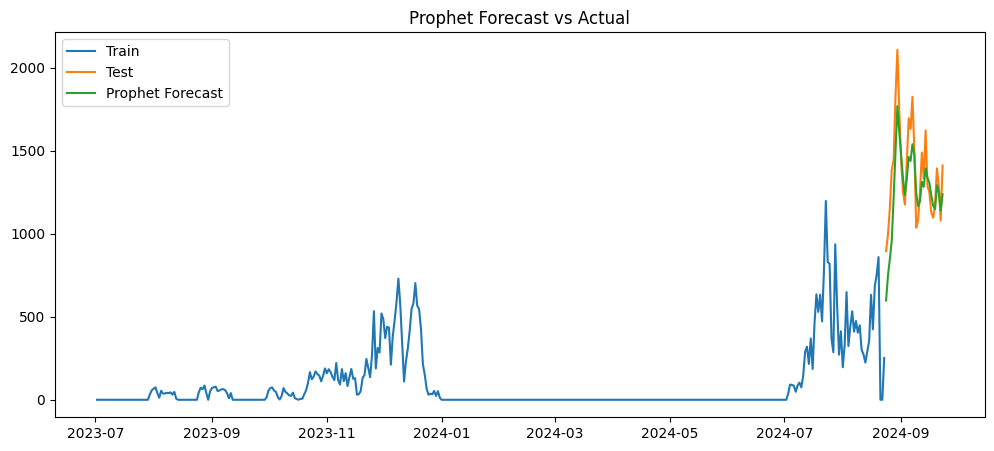

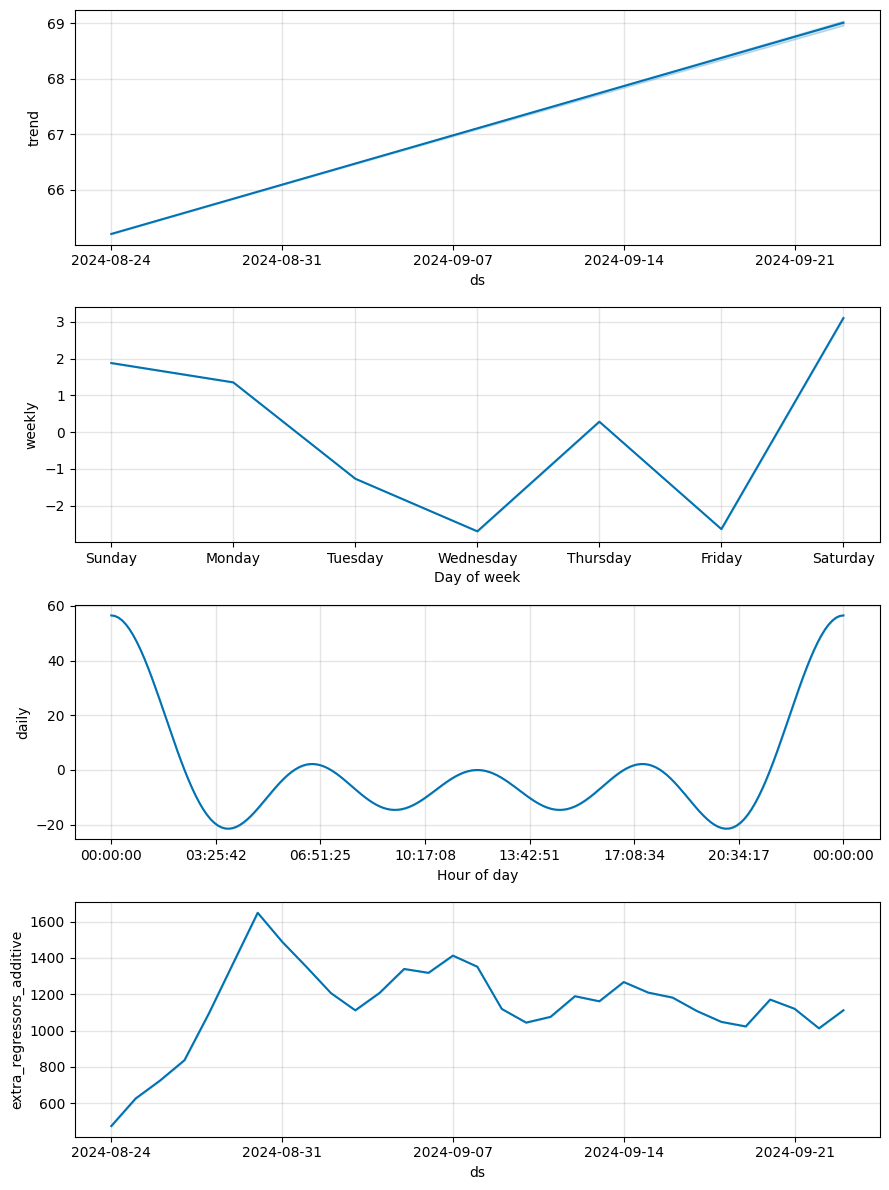

Random Forest RMSE: 515.468413253555
Random Forest MAE: 457.9617699461668


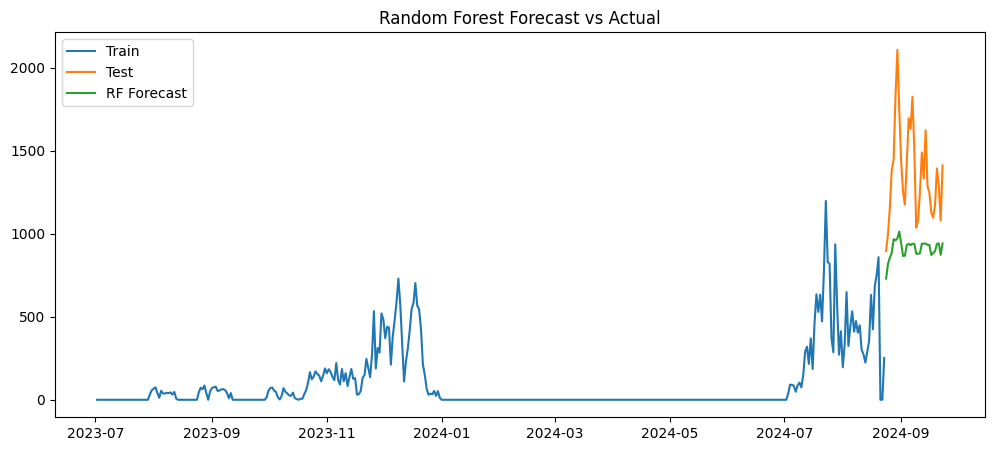

Ensemble RMSE: 331.85815835141324
Ensemble MAE: 282.2155636719637


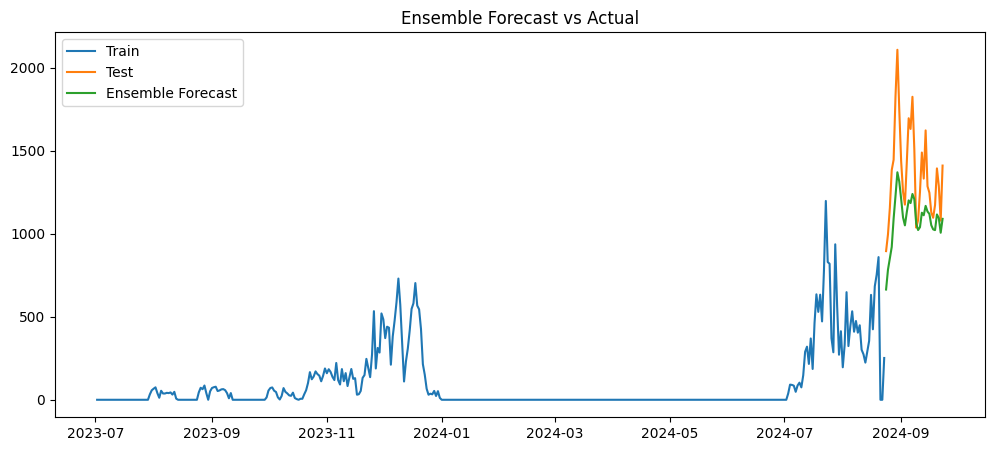

In [ ]:
df = df_daily_merged.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

# Aggregate duplicates
df = df.groupby(df.index).agg({
    'kwh_sum': 'sum',
    'Temperature (°C)_mean': 'mean',
    'Total Precipitation (mm)_sum': 'sum',
    'current_mean': 'mean',
    'current_max': 'max',
    'power_factor_mean': 'mean',
    'voltage_value': 'mean'
})

# Daily frequency + interpolate missing days
df = df.asfreq('D').interpolate()

# Feature Engineering: lags and rolling averages
df['lag1'] = df['kwh_sum'].shift(1)
df['lag7'] = df['kwh_sum'].shift(7)
df['roll7'] = df['kwh_sum'].rolling(7).mean()
df['roll30'] = df['kwh_sum'].rolling(30).mean()
df = df.dropna()

# Train-test split
train = df.loc[:'2024-08-23']
test  = df.loc['2024-08-24':'2024-09-23']


# Define Features
features = ['lag1','lag7','roll7','roll30','current_mean','Temperature (°C)_mean','Total Precipitation (mm)_sum']
target = 'kwh_sum'


X_train = train[features]
y_train = train[target]
X_test  = test[features]
y_test  = test[target]

# Prophet Model
prophet_df = df.reset_index()[['date', target] + features].rename(columns={'date':'ds','kwh_sum':'y'})

prophet_train = prophet_df[prophet_df['ds'] <= '2024-08-23']
prophet_test  = prophet_df[(prophet_df['ds'] >= '2024-08-24') & (prophet_df['ds'] <= '2024-09-23')]

prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)
for col in features:
    prophet.add_regressor(col)

prophet.fit(prophet_train)

future_test = prophet_test[['ds'] + features]
forecast = prophet.predict(future_test)

prophet_rmse = sqrt(mean_squared_error(prophet_test['y'], forecast['yhat']))
prophet_mae  = mean_absolute_error(prophet_test['y'], forecast['yhat'])
print("Prophet RMSE:", prophet_rmse)
print("Prophet MAE:", prophet_mae)

# Plot Prophet
plt.figure(figsize=(12,5))
plt.plot(prophet_train['ds'], prophet_train['y'], label="Train")
plt.plot(prophet_test['ds'], prophet_test['y'], label="Test")
plt.plot(prophet_test['ds'], forecast['yhat'], label="Prophet Forecast")
plt.legend(); plt.title("Prophet Forecast vs Actual"); plt.show()

prophet.plot_components(forecast)
plt.show()

# Random Forest Model
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_rmse = sqrt(mean_squared_error(y_test, rf_pred))
rf_mae  = mean_absolute_error(y_test, rf_pred)
print("Random Forest RMSE:", rf_rmse)
print("Random Forest MAE:", rf_mae)

# Plot RF
plt.figure(figsize=(12,5))
plt.plot(train.index, y_train, label="Train")
plt.plot(test.index, y_test, label="Test")
plt.plot(test.index, rf_pred, label="RF Forecast")
plt.legend(); plt.title("Random Forest Forecast vs Actual"); plt.show()


# Ensemble (Prophet + RF)
ensemble_pred = (forecast['yhat'].values + rf_pred) / 2

ensemble_rmse = sqrt(mean_squared_error(y_test, ensemble_pred))
ensemble_mae  = mean_absolute_error(y_test, ensemble_pred)
print("Ensemble RMSE:", ensemble_rmse)
print("Ensemble MAE:", ensemble_mae)

# Plot Ensemble
plt.figure(figsize=(12,5))
plt.plot(train.index, y_train, label="Train")
plt.plot(test.index, y_test, label="Test")
plt.plot(test.index, ensemble_pred, label="Ensemble Forecast")
plt.legend(); plt.title("Ensemble Forecast vs Actual"); plt.show()


"Maximum Likelihood optimization failed to..." in SARIMAX

/Users/gozal/Documents/Data Science/Watts_UP-Hydropower_Climate_Optimisation/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX RMSE: 5643.120875539378
SARIMAX MAE: 4229.0938386366915


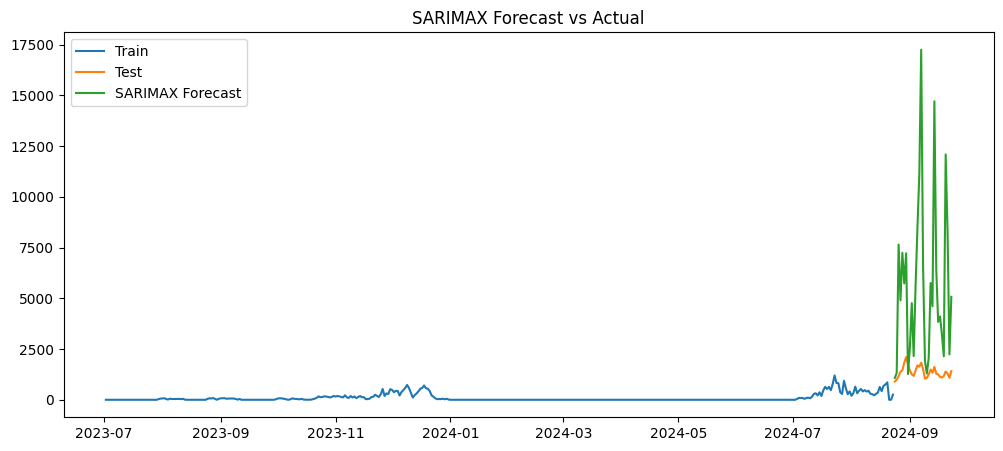

10:16:29 - cmdstanpy - INFO - Chain [1] start processing
10:16:29 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 179.9623759416631
Prophet MAE: 147.3567841466984


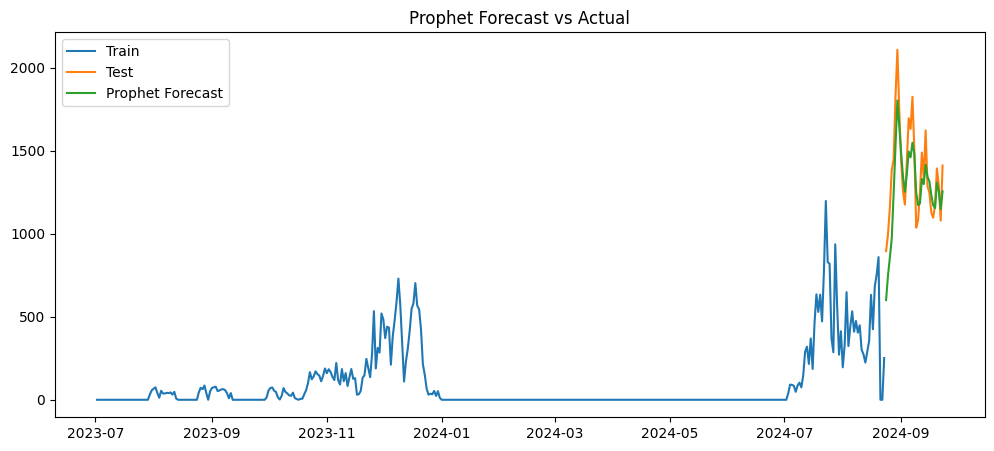

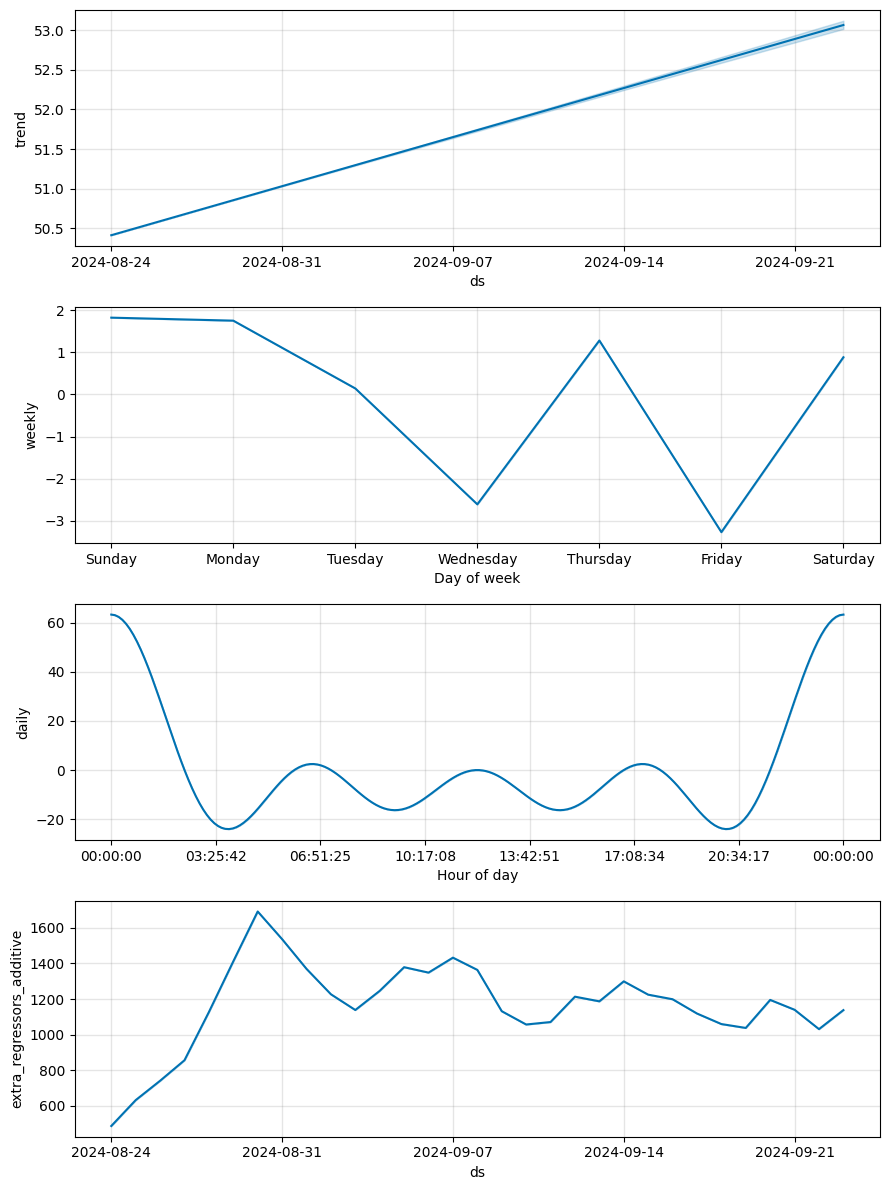

In [ ]:
df = df_daily_merged.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

# Aggregate duplicates (daily)
df = df.groupby(df.index).agg({
    'kwh_sum': 'sum',
    'Temperature (°C)_mean': 'mean',
    'Total Precipitation (mm)_sum': 'sum',
    'Snowfall (mm)_sum': 'sum',
    'Snow Cover (%)_mean': 'mean',
    'current_mean': 'mean',
    'current_max': 'max',
    'power_factor_mean': 'mean',
    'voltage_value': 'mean'
})

# Daily frequency
df = df.asfreq('D').interpolate()

# Feature Engineering

df['lag1'] = df['kwh_sum'].shift(1)
df['lag7'] = df['kwh_sum'].shift(7)
df['roll7'] = df['kwh_sum'].rolling(7).mean()
df['roll30'] = df['kwh_sum'].rolling(30).mean()
df = df.dropna()

# Target & Exogenous
target = 'kwh_sum'
exog_features = [
    'current_mean','current_max','power_factor_mean','voltage_value',
    'Temperature (°C)_mean','Total Precipitation (mm)_sum',
    'Snowfall (mm)_sum','Snow Cover (%)_mean',
    'lag1','lag7','roll7','roll30'
]

# Train-test split
train = df.loc[:'2024-08-23']
test = df.loc['2024-08-24':'2024-09-23']

X_train, y_train = train[exog_features], train[target]
X_test, y_test = test[exog_features], test[target]


# SARIMAX Model
sarimax = SARIMAX(
    np.log1p(y_train),
    exog=X_train,
    order=(1,1,1),
    seasonal_order=(0,1,1,7)
)

sarimax_fit = sarimax.fit(disp=False)

# Forecast
sarimax_pred_log = sarimax_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)
sarimax_pred = np.expm1(sarimax_pred_log)

# Evaluation
print("SARIMAX RMSE:", sqrt(mean_squared_error(y_test, sarimax_pred)))
print("SARIMAX MAE:", mean_absolute_error(y_test, sarimax_pred))

# Plot
plt.figure(figsize=(12,5))
plt.plot(train.index, y_train, label="Train")
plt.plot(test.index, y_test, label="Test")
plt.plot(test.index, sarimax_pred, label="SARIMAX Forecast")
plt.legend(); plt.title("SARIMAX Forecast vs Actual"); plt.show()


# Prophet Model
prophet_df = df.reset_index()[['date', target] + exog_features].rename(columns={'date':'ds','kwh_sum':'y'})

prophet_train = prophet_df[prophet_df['ds'] <= '2024-08-23']
prophet_test = prophet_df[(prophet_df['ds'] >= '2024-08-24') & (prophet_df['ds'] <= '2024-09-23')]

prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)
for col in exog_features:
    prophet.add_regressor(col)

prophet.fit(prophet_train)

# Forecast
future_test = prophet_test[['ds'] + exog_features]
forecast = prophet.predict(future_test)

# Evaluation
print("Prophet RMSE:", sqrt(mean_squared_error(prophet_test['y'], forecast['yhat'])))
print("Prophet MAE:", mean_absolute_error(prophet_test['y'], forecast['yhat']))

# Plot
plt.figure(figsize=(12,5))
plt.plot(prophet_train['ds'], prophet_train['y'], label="Train")
plt.plot(prophet_test['ds'], prophet_test['y'], label="Test")
plt.plot(prophet_test['ds'], forecast['yhat'], label="Prophet Forecast")
plt.legend(); plt.title("Prophet Forecast vs Actual"); plt.show()

# Prophet components (trend, seasonality, regressors)
prophet.plot_components(forecast)
plt.show()


Below Prophet model with best fit.

In [4]:
# Aggregate Duplicates
df = df.groupby(df.index).agg({
    'kwh_sum': 'sum',
    'Temperature (°C)_mean': 'mean',
    'Temperature (°C)_min': 'min',
    'Temperature (°C)_max': 'max',
    'Dewpoint Temperature (°C)_mean': 'mean',
    'Dewpoint Temperature (°C)_min': 'min',
    'Dewpoint Temperature (°C)_max': 'mean',
    'U Wind Component (m/s)_mean': 'mean',
    'V Wind Component (m/s)_mean': 'mean',
    'Total Precipitation (mm)_sum': 'sum',
    'Snowfall (mm)_sum': 'sum',
    'Snow Cover (%)_mean': 'mean',
    'current_mean': 'mean',
    'current_max': 'max',
    'current_std': 'mean',
    'power_factor_mean': 'mean',
    'voltage_value': 'mean'
})
# Set daily frequency and interpolate missing days
df = df.asfreq('D').interpolate()


# Feature Engineering
df['kwh_sum_lag1'] = df['kwh_sum'].shift(1)
df['kwh_sum_lag7'] = df['kwh_sum'].shift(7)
df['kwh_sum_roll7'] = df['kwh_sum'].rolling(7).mean()
df['kwh_sum_roll30'] = df['kwh_sum'].rolling(30).mean()
df['HDD'] = np.maximum(0, 18 - df['Temperature (°C)_mean'])
df['CDD'] = np.maximum(0, df['Temperature (°C)_mean'] - 22)

df = df.dropna()

In [5]:
# Define Target & Features
target = 'kwh_sum'

# Optimized features
device_features = ['current_mean', 'current_max', 'power_factor_mean', 'voltage_value']
climate_features = ['Temperature (°C)_mean', 'Total Precipitation (mm)_sum',
                    'Snowfall (mm)_sum', 'Snow Cover (%)_mean']
time_series_features = ['kwh_sum_lag1', 'kwh_sum_lag7', 'kwh_sum_roll7', 'kwh_sum_roll30', 'HDD', 'CDD']

engineered_features = device_features + climate_features + time_series_features

In [ ]:
# Update exog_features to use correct lag/rolling column names
#exog_features_new = [
	#'Temperature (°C)_mean', 'Total Precipitation (mm)_sum', 'Snowfall (mm)_sum', 'Snow Cover (%)_mean',
	#'current_mean', 'current_max', 'power_factor_mean', 'voltage_value',
	#'kwh_sum_lag1', 'kwh_sum_lag7', 'kwh_sum_roll7', 'kwh_sum_roll30'
#]
#target = 'kwh_sum'

In [6]:
# Train-Test Split
train = df.loc[:'2024-08-23']
test = df.loc['2024-08-24':'2024-09-23']

X_train = train[engineered_features]
y_train = train[target]
X_test = test[engineered_features]
y_test = test[target]


In [7]:
# Scale Exogenous Variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [8]:
# SARIMAX Model (log-transform)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

sarimax_model = SARIMAX(
    y_train_log,
    exog=X_train_scaled,
    order=(1,1,0),
    seasonal_order=(0,1,1,7)
)

sarimax_fit = sarimax_model.fit(disp=False, method='powell', maxiter=500)

# Forecast
sarimax_pred_log = sarimax_fit.predict(start=y_test_log.index[0], end=y_test_log.index[-1], exog=X_test_scaled)
sarimax_pred = np.expm1(sarimax_pred_log)

# Evaluate SARIMAX
rmse_sarimax = sqrt(mean_squared_error(y_test, sarimax_pred))
mae_sarimax = mean_absolute_error(y_test, sarimax_pred)
print("SARIMAX RMSE:", rmse_sarimax)
print("SARIMAX MAE:", mae_sarimax)


SARIMAX RMSE: 11191.26408449868
SARIMAX MAE: 8724.351482701988


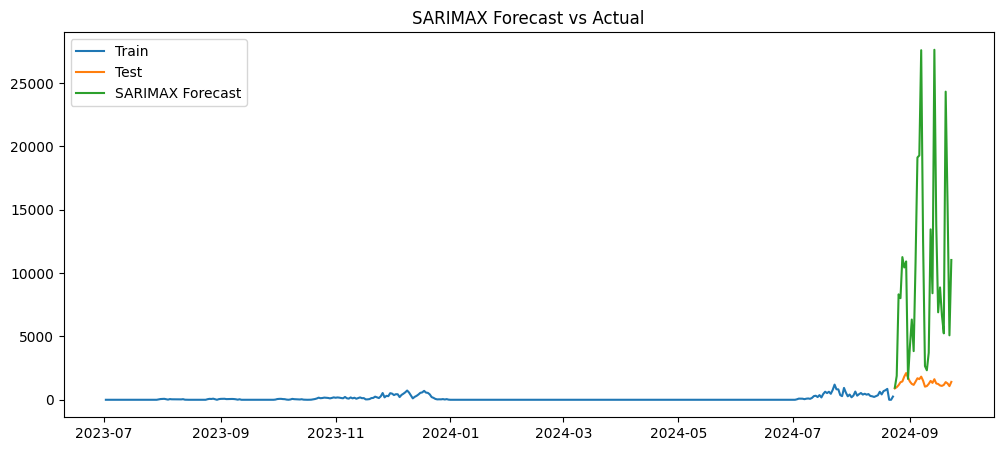

In [9]:
# Plot SARIMAX
plt.figure(figsize=(12,5))
plt.plot(train.index, y_train, label='Train')
plt.plot(test.index, y_test, label='Test')
plt.plot(test.index, sarimax_pred, label='SARIMAX Forecast')
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show()

In [ ]:
# Prophet Model
prophet_df = df[[target] + climate_features + device_features].reset_index().rename(columns={'date':'ds', target:'y'})

prophet_train = prophet_df[prophet_df['ds'] <= '2024-08-23']
prophet_test = prophet_df[(prophet_df['ds'] >= '2024-08-24') & (prophet_df['ds'] <= '2024-09-23')]

prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
for col in climate_features + device_features:
    prophet_model.add_regressor(col)

prophet_model.fit(prophet_train)

# Extended Forecast with "prophet_model.predict(future_test), auto-extend predictions into the future."
future_test = prophet_test[['ds'] + climate_features + device_features]
prophet_forecast = prophet_model.predict(future_test)

# Additionally can be checked with:
# future = prophet_model.make_future_dataframe(periods=60)   # extend 60 days beyond training
# prophet_forecast = prophet_model.predict(future)


# Evaluate Prophet
rmse_prophet = sqrt(mean_squared_error(prophet_test['y'], prophet_forecast['yhat']))
mae_prophet = mean_absolute_error(prophet_test['y'], prophet_forecast['yhat'])
print("Prophet RMSE:", rmse_prophet)
print("Prophet MAE:", mae_prophet)

02:42:31 - cmdstanpy - INFO - Chain [1] start processing
02:42:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 2.9246124840229406
Prophet MAE: 0.9928923113533312


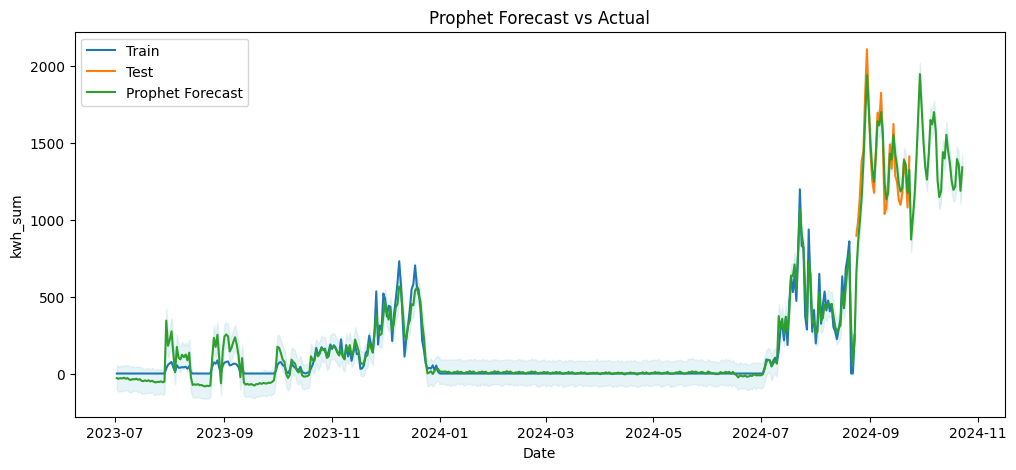

In [15]:
# Plot actuals vs Prophet forecast
plt.figure(figsize=(12,5))
plt.plot(prophet_train['ds'], prophet_train['y'], label='Train')       # Train actuals
plt.plot(prophet_test['ds'], prophet_test['y'], label='Test')          # Test actuals
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast')  # Forecast
plt.fill_between(prophet_forecast['ds'], prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='lightblue', alpha=0.3)  # Uncertainty interval
plt.legend()
plt.title("Prophet Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel(target)
plt.show()

** Baseline model with Sarimax and Prophet

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from math import sqrt
from prophet import Prophet

In [ ]:

# Ensure datetime and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df = df.set_index('date')

# Aggregate Duplicates
df = df.groupby(df.index).agg({
    'kwh_sum': 'sum',
    'Temperature (°C)_mean': 'mean',
    'Temperature (°C)_min': 'min',
    'Temperature (°C)_max': 'max',
    'Dewpoint Temperature (°C)_mean': 'mean',
    'Dewpoint Temperature (°C)_min': 'min',
    'Dewpoint Temperature (°C)_max': 'mean',
    'U Wind Component (m/s)_mean': 'mean',
    'V Wind Component (m/s)_mean': 'mean',
    'Total Precipitation (mm)_sum': 'sum',
    'Snowfall (mm)_sum': 'sum',
    'Snow Cover (%)_mean': 'mean',
    'current_mean': 'mean',
    'current_max': 'max',
    'current_std': 'mean',
    'power_factor_mean': 'mean',
    'voltage_value': 'mean'
})

# Set daily frequency and interpolate missing days
df = df.asfreq('D').interpolate()


# Feature Engineering
df['kwh_sum_lag1'] = df['kwh_sum'].shift(1)
df['kwh_sum_lag7'] = df['kwh_sum'].shift(7)
df['kwh_sum_roll7'] = df['kwh_sum'].rolling(7).mean()
df['kwh_sum_roll30'] = df['kwh_sum'].rolling(30).mean()
df['HDD'] = np.maximum(0, 18 - df['Temperature (°C)_mean'])
df['CDD'] = np.maximum(0, df['Temperature (°C)_mean'] - 22)

df = df.dropna()


# Define Target & Features
target = 'kwh_sum'

climate_features = [
    'Temperature (°C)_mean', 'Total Precipitation (mm)_sum'
]
device_features = ['current_mean']
engineered_features = ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7','kwh_sum_roll30','HDD','CDD']

exog_features = climate_features + device_features + engineered_features


In [20]:
# Train-Test Split
train = df.loc[:'2024-08-23']
test = df.loc['2024-08-24':'2024-09-23']

X_train = train[exog_features]
y_train = train[target]
X_test = test[exog_features]
y_test = test[target]


In [21]:
# Scale Exogenous Variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [22]:
# SARIMAX Model (log-transform)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

sarimax_model = SARIMAX(
    y_train_log,
    exog=X_train_scaled,
    order=(1,1,0),
    seasonal_order=(0,1,1,7)
)

sarimax_fit = sarimax_model.fit(disp=False, method='powell', maxiter=500)

# Forecast
sarimax_pred_log = sarimax_fit.predict(start=y_test_log.index[0], end=y_test_log.index[-1], exog=X_test_scaled)
sarimax_pred = np.expm1(sarimax_pred_log)

# Evaluate SARIMAX
rmse_sarimax = sqrt(mean_squared_error(y_test, sarimax_pred))
mae_sarimax = mean_absolute_error(y_test, sarimax_pred)
print("SARIMAX RMSE:", rmse_sarimax)
print("SARIMAX MAE:", mae_sarimax)


SARIMAX RMSE: 33335.29325775831
SARIMAX MAE: 20126.062347323463


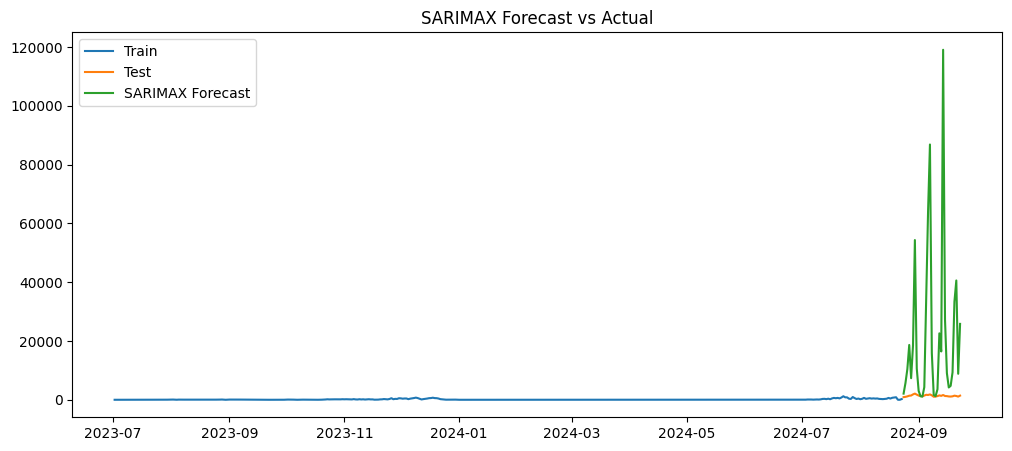

In [23]:
# Plot SARIMAX
plt.figure(figsize=(12,5))
plt.plot(train.index, y_train, label='Train')
plt.plot(test.index, y_test, label='Test')
plt.plot(test.index, sarimax_pred, label='SARIMAX Forecast')
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show()

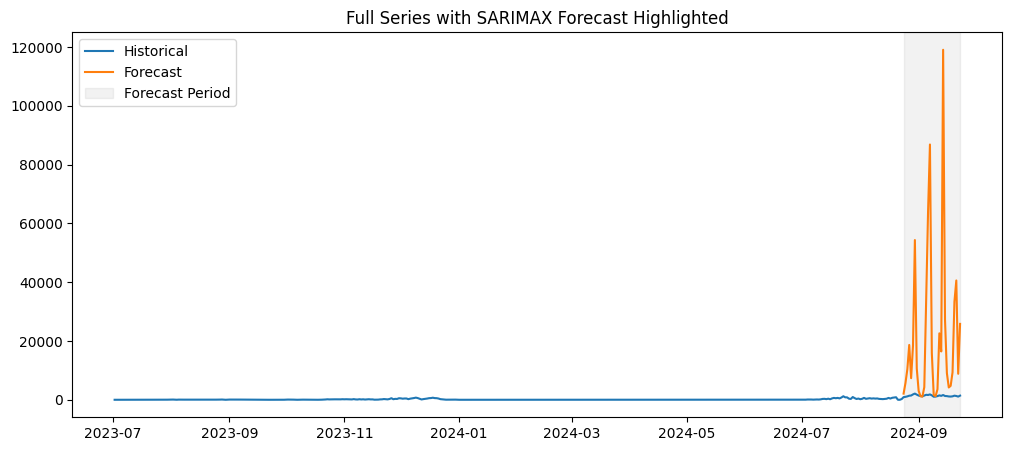

In [24]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df[target], label='Historical')
plt.plot(test.index, sarimax_pred, label='Forecast')
plt.axvspan(test.index[0], test.index[-1], color='grey', alpha=0.1, label='Forecast Period')
plt.legend()
plt.title("Full Series with SARIMAX Forecast Highlighted")
plt.show()

In [25]:
# Prophet Model
prophet_df = df[[target] + climate_features + device_features].reset_index().rename(columns={'date':'ds', target:'y'})

prophet_train = prophet_df[prophet_df['ds'] <= '2024-08-23']
prophet_test = prophet_df[(prophet_df['ds'] >= '2024-08-24') & (prophet_df['ds'] <= '2024-09-23')]

prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
for col in climate_features + device_features:
    prophet_model.add_regressor(col)

prophet_model.fit(prophet_train)

future_test = prophet_test[['ds'] + climate_features + device_features]
prophet_forecast = prophet_model.predict(future_test)

# Evaluate Prophet
rmse_prophet = sqrt(mean_squared_error(prophet_test['y'], prophet_forecast['yhat']))
mae_prophet = mean_absolute_error(prophet_test['y'], prophet_forecast['yhat'])
print("Prophet RMSE:", rmse_prophet)
print("Prophet MAE:", mae_prophet)

13:10:40 - cmdstanpy - INFO - Chain [1] start processing
13:10:40 - cmdstanpy - INFO - Chain [1] done processing
13:10:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:10:40 - cmdstanpy - INFO - Chain [1] start processing
13:10:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 464.05220001830133
Prophet MAE: 428.6513569861451


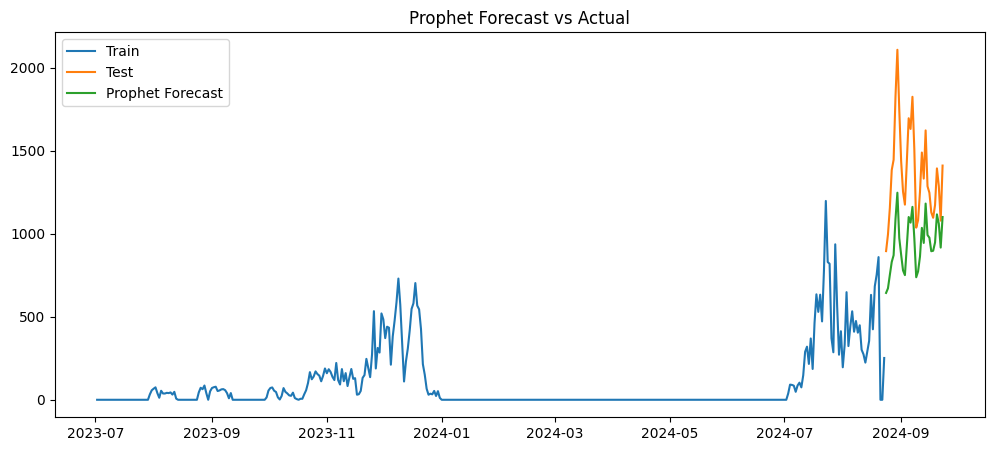

In [26]:
# Plot Prophet
plt.figure(figsize=(12,5))
plt.plot(train.index, y_train, label='Train')
plt.plot(test.index, y_test, label='Test')
plt.plot(test.index, prophet_forecast['yhat'].values, label='Prophet Forecast')
plt.legend()
plt.title("Prophet Forecast vs Actual")
plt.show()

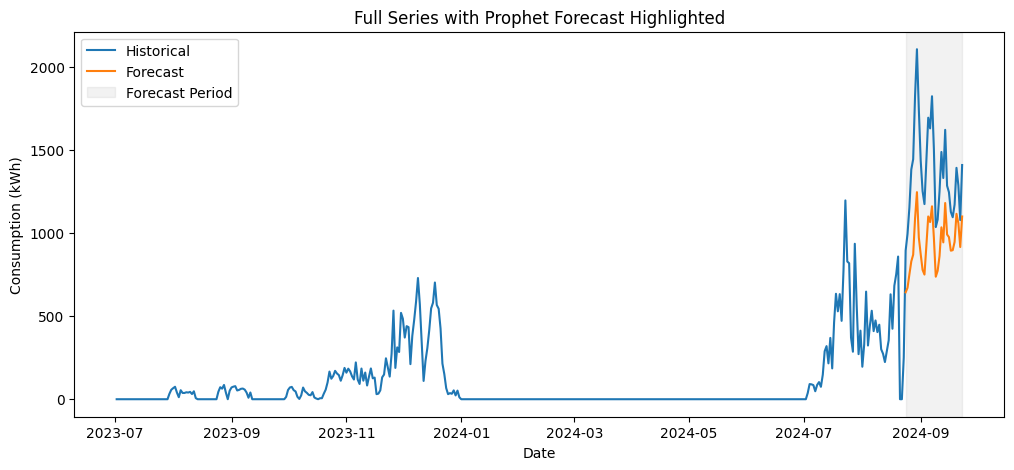

In [27]:
#Full Series Forecast (Historical + Test + Future)
plt.figure(figsize=(12,5))
plt.plot(df.index, df[target], label='Historical')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Forecast')
plt.axvspan(prophet_forecast['ds'].iloc[0], prophet_forecast['ds'].iloc[-1], color='grey', alpha=0.1, label='Forecast Period')
plt.legend()
plt.title("Full Series with Prophet Forecast Highlighted")
plt.xlabel("Date")
plt.ylabel("Consumption (kWh)")
plt.show()

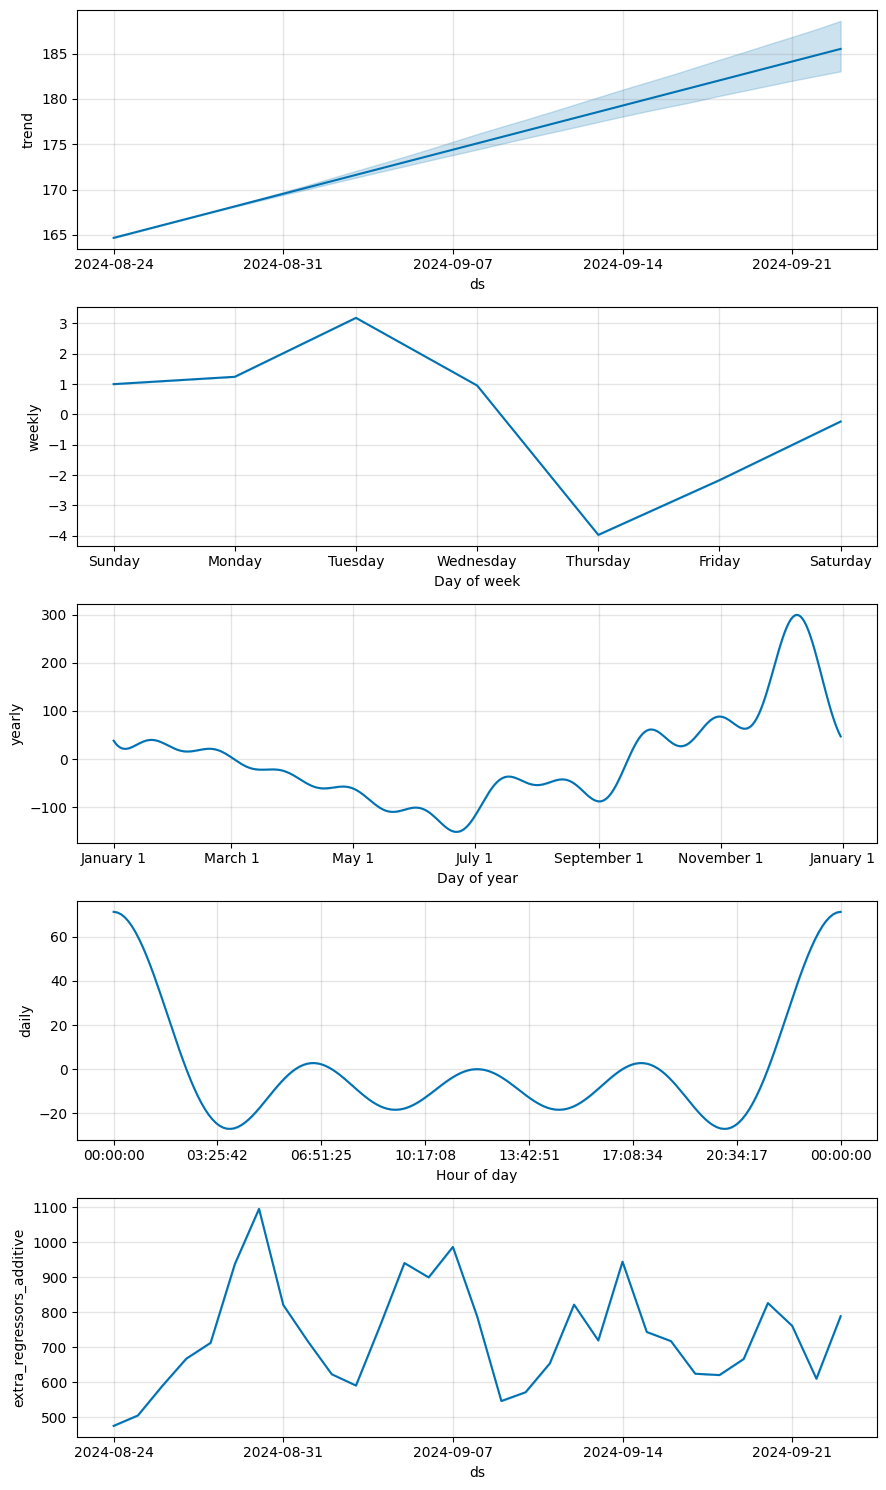

In [28]:
#Components Plot (Trend + Seasonality + Regressors)
prophet_model.plot_components(prophet_forecast)
plt.show()

In [31]:
df_climate = pd.read_csv('climate_data.csv')

In [32]:
df_climate.head(5)

,Date Time,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),i,j,...,q,r,s,t,u,v,w,x,y,z
0,2023-06-03T13:00:00,7.199731,-2.448126,-0.034195,0.060989,0.000377,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-06-03T14:00:00,6.000620,-2.597540,-0.080688,0.018585,0.000398,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-06-03T15:00:00,4.789972,-2.696951,0.057449,-0.352020,0.000418,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-06-03T16:00:00,3.158746,-2.879324,0.051529,-0.608948,0.000420,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-06-03T17:00:00,1.671426,-3.255606,0.056137,-0.739838,0.000420,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_climate = df_climate.drop(columns=['i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'])

In [34]:
df_climate.columns

Index(['Date Time', 'Temperature (°C)', 'Dewpoint Temperature (°C)',
       'U Wind Component (m/s)', 'V Wind Component (m/s)',
       'Total Precipitation (mm)', 'Snowfall (mm)', 'Snow Cover (%)'],
      dtype='object')

### Climate only forecast.

In [35]:
# Prepare Climate Dataset
df_climate['Date Time'] = pd.to_datetime(df_climate['Date Time'])
df_climate.set_index('Date Time', inplace=True)